In [1]:
import cv2
import numpy as np
from PIL import Image,ImageDraw,ImageColor,ImageFont
import matplotlib.pyplot as plt
import matplotlib
import webcolors
import os

Size  1200 936
Image mode:  RGB


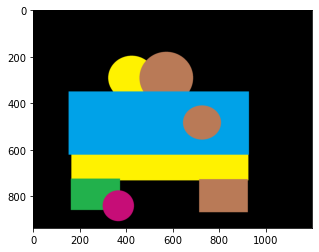

In [2]:
# file_name='resized0019_top_flat'
# file_name2="0019_top_flat"

file_name='resizedexample'
file_name2="example"

# Takes an image object and shows the image
def show_image(img):
    print("Size ",img.shape[1],img.shape[0])
    plt.imshow(img)
    img = Image.fromarray(img)
    print("Image mode: ",img.mode)
    
# Takes a list of image objects and show all of them
def show_imglist(img_list):
    for i in range(len(img_list)):
        print(img_list[i][1])
        plt.imshow(img_list[i][0], interpolation='nearest')
        plt.show()
    
def RGBImage(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print("Image converted to RGB")
    return img

file_path ='resized/'+file_name+'.png'
file_path2='sampleImages/'+file_name2+'.png'
cv_img = cv2.imread(file_path)
# cv_img=RGBImage(cv_img)

show_image(cv_img)

length: 6
[198  13 119]


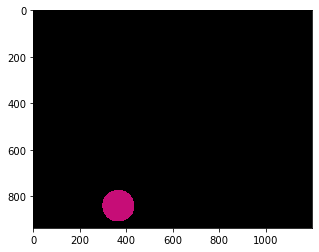

[  0 162 232]


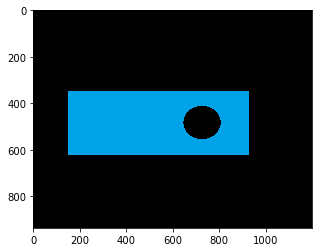

[ 34 177  76]


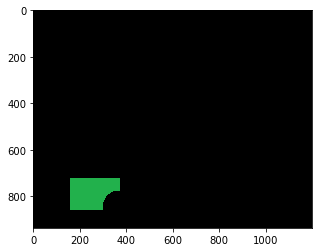

[255 242   0]


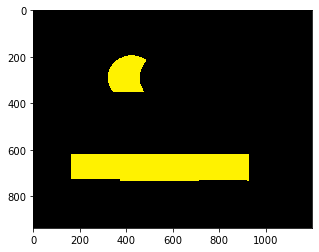

[185 122  87]


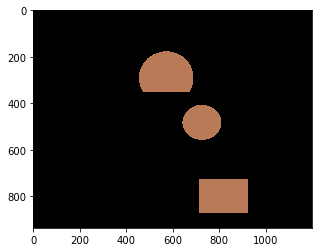

[0 0 0]


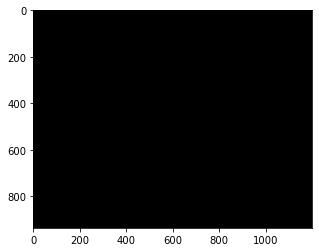

In [3]:
def getRGBColorPalette(file_path):
    img=Image.open(file_path)
    colors = img.convert('RGB').getcolors()
    colorlist=[]

    for i in range(len(colors)):
        colorlist.append(colors[i][1])
        
    print("length:",len(colorlist))
    return colorlist

def getLowRGB(colorList):
    rgb_palette=colorList
    low_rgb=[]
    for i in rgb_palette:
        rgb1=i
        val=[]
        for i in range(len(rgb1)):
            if(rgb1[i]!=0):
                val.append(abs(rgb1[i] - 1))
            else:
                val.append(rgb1[i])
        rgb2=(val[0],val[1],val[2])
        np_rgb = np.asarray(rgb2)
        low_rgb.append(np_rgb)
    return low_rgb
    
def getHighRGB(colorList):
    rgb_palette=colorList
    high_rgb=[]
    for i in rgb_palette:
        rgb1=i
        val=[]
        for i in range(len(rgb1)):
            rgb2=(rgb1[0],rgb1[1],rgb1[2])
        np_rgb = np.asarray(rgb2)
        high_rgb.append(np_rgb)
    return high_rgb

#Returns Dilated image
def DilateImage2(img):
    cv2.imshow('Original', img)
    kernel = np.ones((5, 5), 'uint8')
    dilate_img = cv2.dilate(img, kernel, iterations=1)
    return dilate_img

#It takes rgbimage and the color pallete as input and returns dilated masked images
def GetMaskSegment(rgb_image,colorList):
    low=getLowRGB(colorList)
    high=getHighRGB(colorList)
    
    imglists=[]
    
    for i in range(len(low)):
        mask = cv2.inRange(rgb_image, low[i], high[i])
        res = cv2.bitwise_and(rgb_image,rgb_image, mask= mask)
        res= DilateImage2(res)
        imglists.append([res,high[i]])
        
    return imglists

# Returns first round of masked images
def FirstMaskSegmentation():
    rgb_colorList=getRGBColorPalette(file_path2)
    img_list=GetMaskSegment(cv_img,rgb_colorList)
    return img_list

show_imglist(FirstMaskSegmentation())

length: 6
[198  13 119]


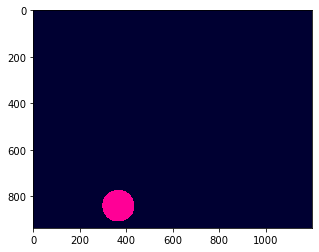

[  0 162 232]


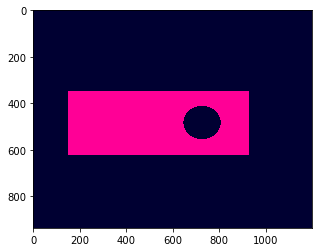

[ 34 177  76]


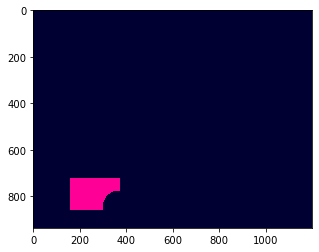

[255 242   0]


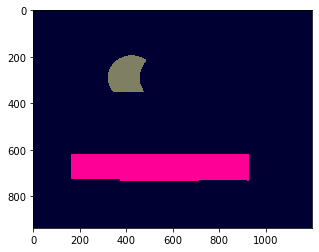

[185 122  87]


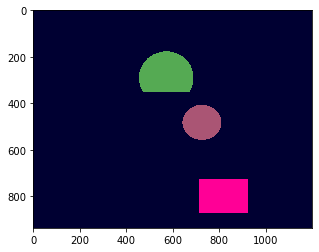

[0 0 0]


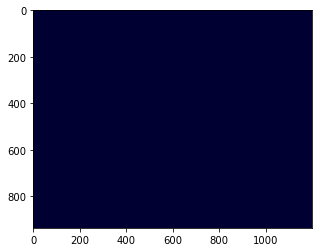

In [4]:
def apply_lut(src, lut):
    dst = lut[src]
    return dst

def ComponentLabeling(img):
    _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    n_components, component_ids = cv2.connectedComponents(mask)

    # Initialize look up tables with arbitrary data for demonstration
    LUT1 = np.linspace(0, 255, n_components).astype(np.uint16)
    LUT2 = np.linspace(255, 0, n_components).astype(np.uint16)
    LUT3 = np.linspace(50, 150, n_components).astype(np.uint16)
    LUT2[0] = 0
    
    r = apply_lut(component_ids, LUT1)
    g = apply_lut(component_ids, LUT2)
    b = apply_lut(component_ids, LUT3)

    rgb = np.dstack((r, g, b)).astype(np.uint8)
    
    return rgb

def RGBtoGrayImage(rgbimg):
    grayImage = cv2.cvtColor(rgbimg, cv2.COLOR_RGB2GRAY)
    (thresh, im_bw) = cv2.threshold(grayImage, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return im_bw

# Takes list of images and does labelling for each of the images in the list and returns new labelled image list
def GetLabel_imglist(img_list):
    label_imglist=[]
    for i in range(len(img_list)):
        gray_im=RGBtoGrayImage(img_list[i][0])
        label_img=ComponentLabeling(gray_im)
        label_imglist.append([label_img,img_list[i][1]])
    return label_imglist

img_list=FirstMaskSegmentation()
show_imglist(GetLabel_imglist(img_list))

length: 6
[198  13 119]


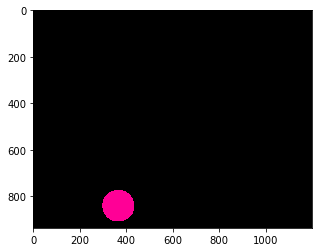

[  0 162 232]


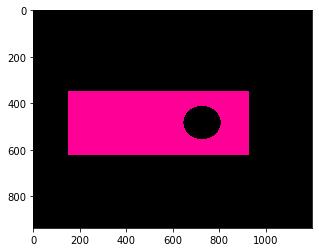

[ 34 177  76]


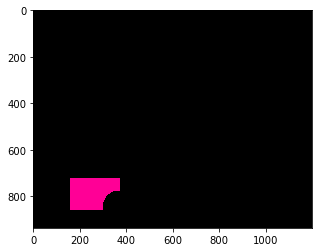

[255 242   0]


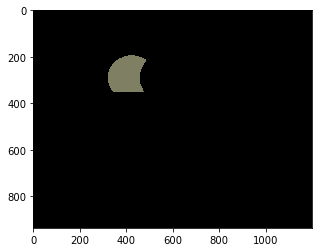

[255 242   0]


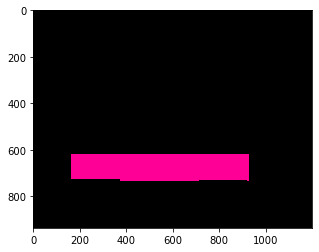

[185 122  87]


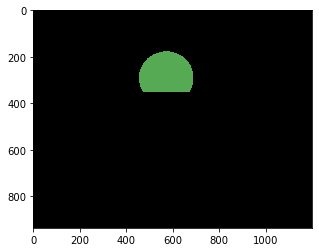

[185 122  87]


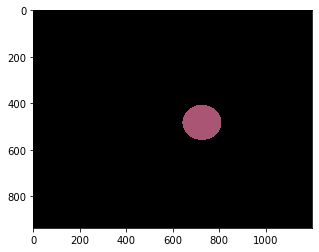

[185 122  87]


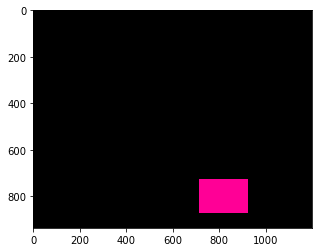

In [5]:
def RemoveSpecificValue(input_list,val):
    new_list=[]
    for i in input_list:
        if(i!=val):
            new_list.append(i)
    return new_list

def GetBgPixVal(img):
    [r,g,b] = img[0, 0]
#     a='#%02x%02x%02x' % (r,g,b)
    return [r,g,b]

def hexTOrgb(input_list):
    print("converting hexlist to rgblist...")
    rgb_list=[]
    for i in input_list:
        rgb_list.append(ImageColor.getcolor(i, "RGB"))
    return rgb_list

def getColorPalette(img):
    unq_pix= np.unique(img.reshape(-1, img.shape[2]), axis=0)
    value=GetBgPixVal(img)
    unq_pix=unq_pix.tolist()
    if value in unq_pix:
        del unq_pix[unq_pix.index(value)]
    return unq_pix

def GetSecondMaskSegment(rgb_image,colorList):
    low=getLowRGB(colorList)
    high=getHighRGB(colorList)
    
    imglists=[]
    
    for i in range(len(low)):
        mask = cv2.inRange(rgb_image, low[i], high[i])
        res = cv2.bitwise_and(rgb_image,rgb_image, mask= mask)
        imglists.append(res)
        
    return imglists


# Creates mask for each of the labelled images. and returns a new list.
def SecondMaskSegmentation():
    img_list2=[]
    img_list=FirstMaskSegmentation()
    label_imglist=GetLabel_imglist(img_list)
    for i in range(len(label_imglist)):
        img=label_imglist[i][0]
        colorname=label_imglist[i][1]
        colorlist=getColorPalette(img)
        sec_imglist=GetSecondMaskSegment(img,colorlist)
        for j in sec_imglist:
            img_list2.append([j,colorname])
    return img_list2
        
show_imglist(SecondMaskSegmentation())

In [6]:
region_list=SecondMaskSegmentation()
region_colorlist=[]
for i in range(len(region_list)):
    colorval=tuple(region_list[i][1])
    colorval='#%02x%02x%02x' % colorval
    region_colorlist.append(colorval)
print(region_colorlist)

length: 6
['#c60d77', '#00a2e8', '#22b14c', '#fff200', '#fff200', '#b97a57', '#b97a57', '#b97a57']


In [7]:
def DilateImage(img):
    cv2.imshow('Original', img)
    kernel = np.ones((5, 5), 'uint8')
    dilate_img = cv2.dilate(img, kernel, iterations=2)
#     plt.imshow(dilate_img, interpolation='nearest')
#     plt.show()
    
    return dilate_img

def CheckConnectivity(img):
    connection=False
    unq_val=np.unique(img.reshape(-1, img.shape[2]), axis = 0)
    total_unqval= len(unq_val)-1
    if(total_unqval==1):
        connection=True
    else:
        connection=False
    return connection

def RegionConnectivity(region1, region2):
#     region1=DilateImage(region1)
#     region2=DilateImage(region2)
    merged_region=region1+region2
    merged_region=RGBtoGrayImage(merged_region)
    merged_region=ComponentLabeling(merged_region)
    plt.imshow(merged_region, interpolation='nearest')
    plt.show()
    check_con=CheckConnectivity(merged_region)
    return check_con

loop  0


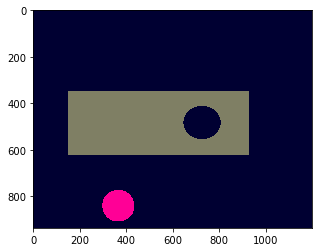

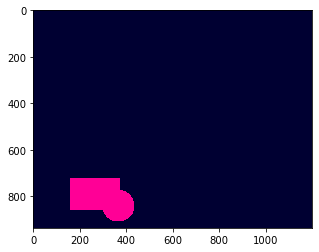

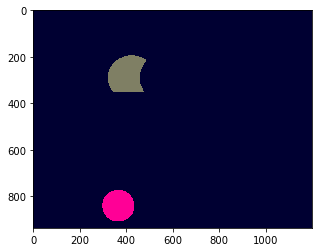

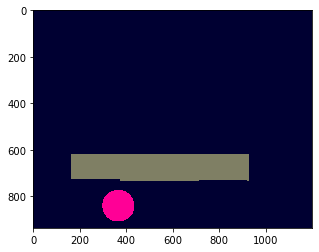

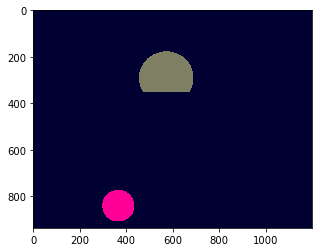

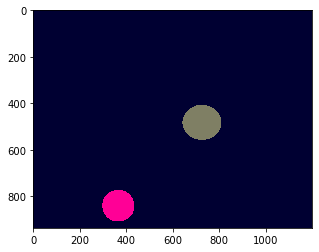

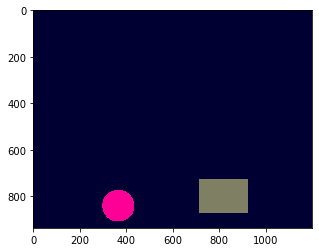

loop  1


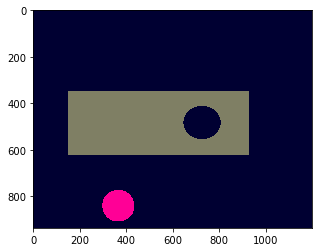

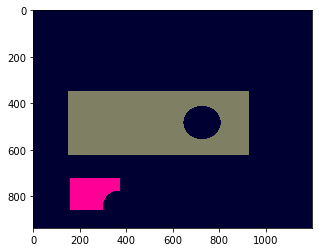

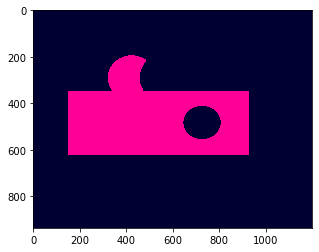

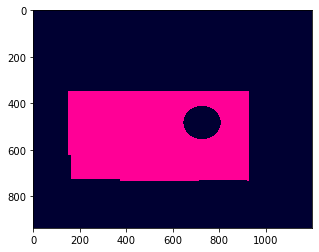

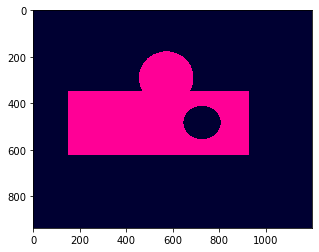

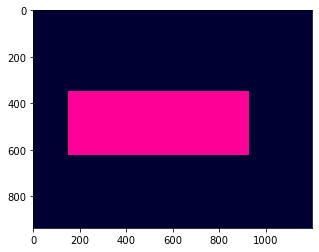

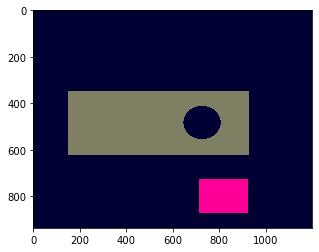

loop  2


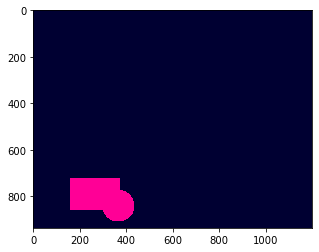

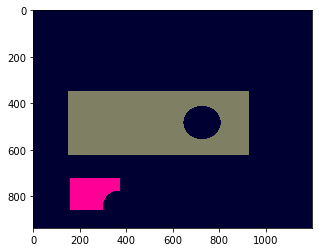

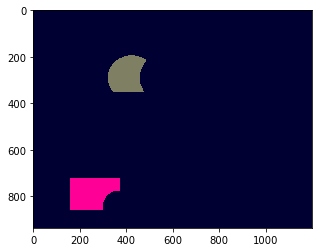

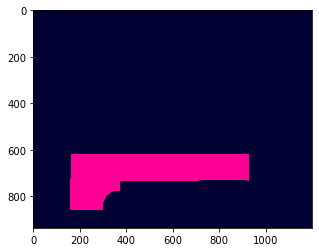

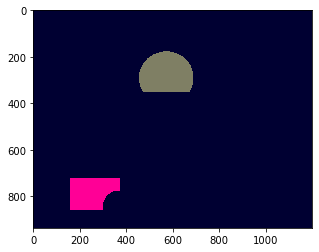

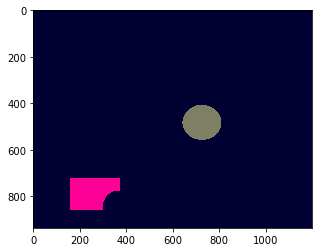

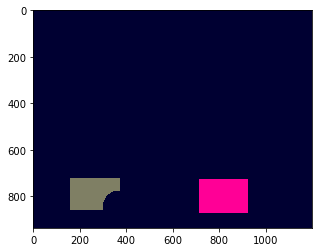

loop  3


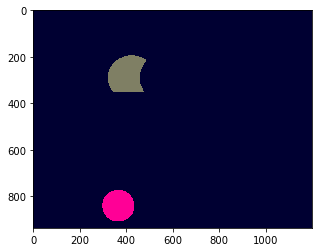

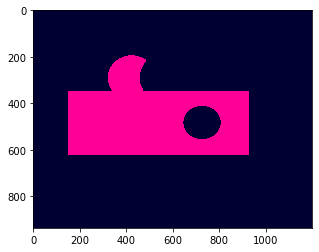

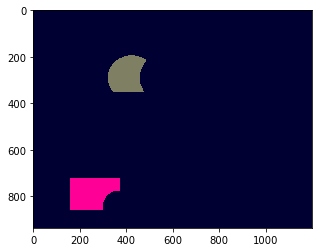

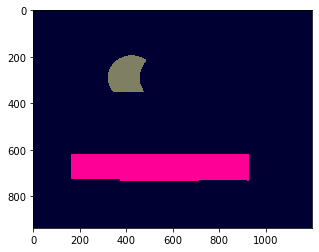

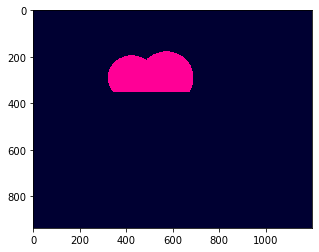

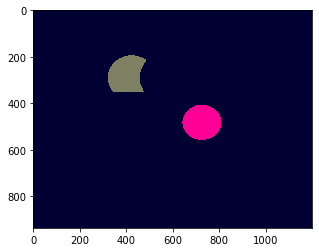

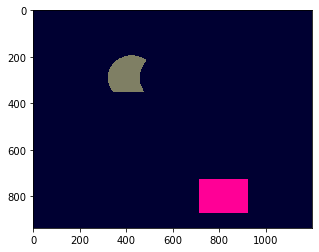

loop  4


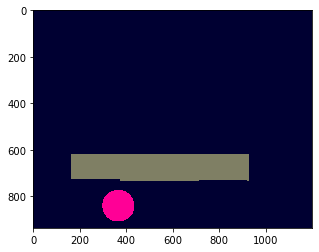

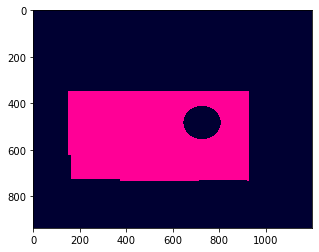

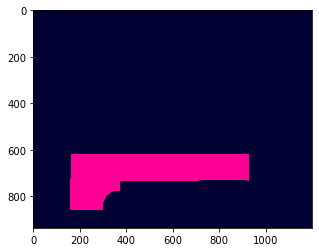

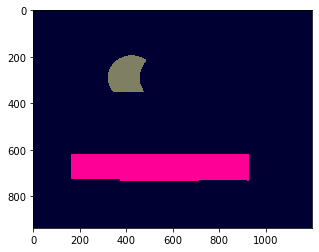

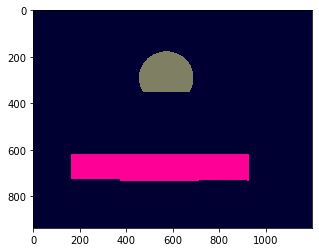

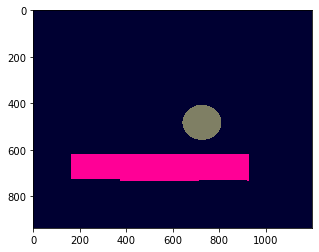

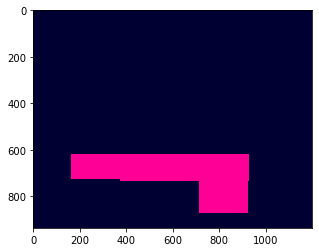

loop  5


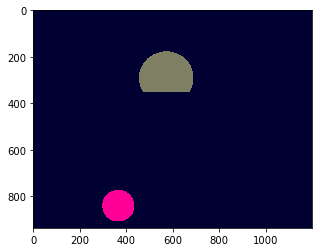

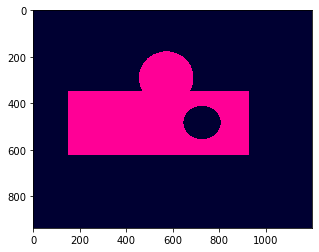

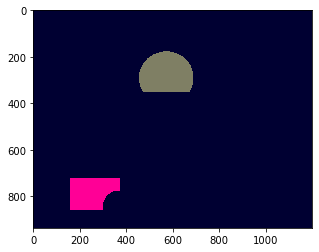

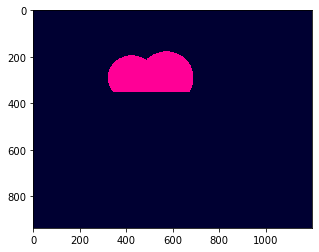

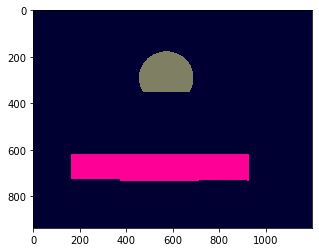

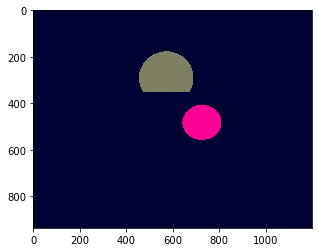

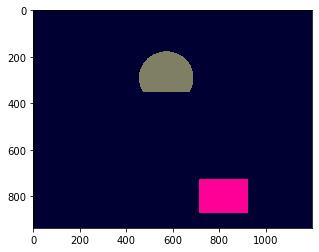

loop  6


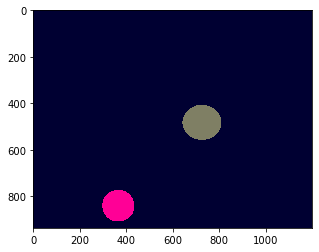

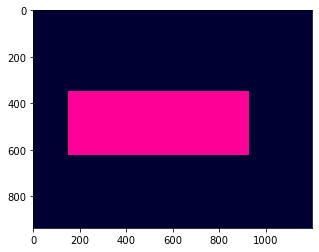

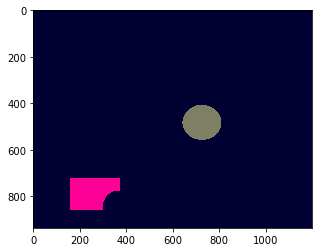

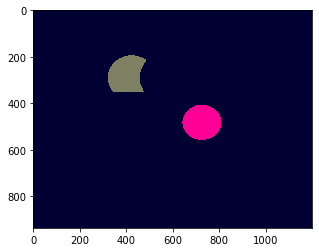

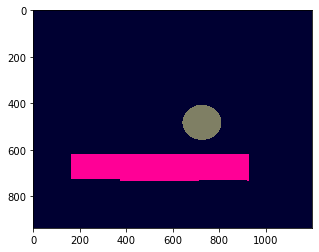

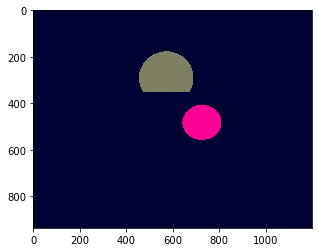

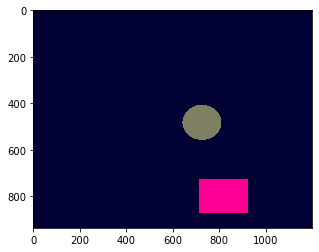

loop  7


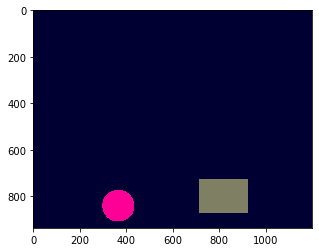

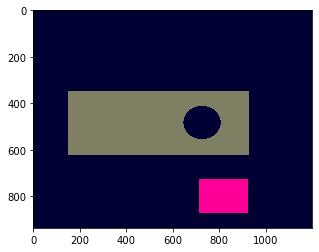

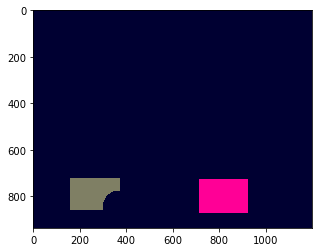

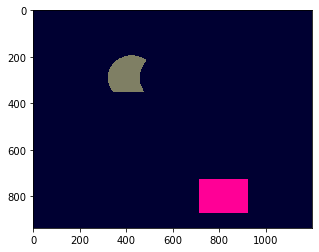

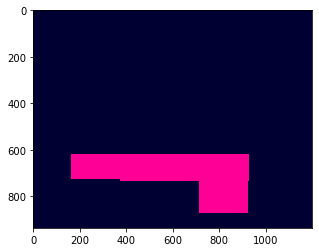

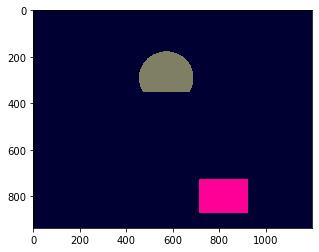

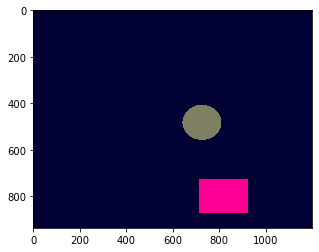

[(0, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 4), (3, 1), (3, 5), (4, 1), (4, 2), (4, 7), (5, 1), (5, 3), (6, 1), (7, 4)]
['#00a2e8', '#22b14c', '#fff200', '#fff200', '#b97a57', '#b97a57', '#b97a57', '#c60d77', '#22b14c', '#fff200', '#fff200', '#b97a57', '#b97a57', '#b97a57', '#c60d77', '#00a2e8', '#fff200', '#fff200', '#b97a57', '#b97a57', '#b97a57', '#c60d77', '#00a2e8', '#22b14c', '#fff200', '#b97a57', '#b97a57', '#b97a57', '#c60d77', '#00a2e8', '#22b14c', '#fff200', '#b97a57', '#b97a57', '#b97a57', '#c60d77', '#00a2e8', '#22b14c', '#fff200', '#fff200', '#b97a57', '#b97a57', '#c60d77', '#00a2e8', '#22b14c', '#fff200', '#fff200', '#b97a57', '#b97a57', '#c60d77', '#00a2e8', '#22b14c', '#fff200', '#fff200', '#b97a57', '#b97a57']


In [9]:
from pyvis.network import Network
net=Network()
    
region_clrlist=[]
node_list=[]
edge_list=[]
for k in range(len(region_list)):
    print("loop ",k)
    compare_img=region_list[k][0]
    for i in range(len(region_list)):
        if(i!=k):
            colorval=tuple(region_list[i][1])
            colorval='#%02x%02x%02x' % colorval
            node_list.append(i)
            region_clrlist.append(colorval)
            check= RegionConnectivity(compare_img,region_list[i][0])
            if(check==True):
                edge_tuple=(k,i)
                edge_list.append(edge_tuple)

                                                      
print(edge_list)
print(region_clrlist)

net.add_nodes(node_list,label=region_clrlist,color=region_clrlist)
net.add_edges(edge_list)
    
net.show("hello.html") 